In [71]:
import pandas as pd
import numpy as np
import sys
import csv
import math
import gensim
from scipy import sparse
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')
# Code source: https://degravek.github.io/project-pages/project1/2017/04/28/New-Notebook/
# Dataset from Chakraborty et al. (https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

[nltk_data] Downloading package stopwords to /Users/matt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/matt/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [30]:
class DataCleaning():
  
    # API to convert true, mostly-true and half-true to true
    # false, barely-true and pants-fire to false

    def convertMulticlassToBinaryclass(self, r):
        v = r['label'].lower()
        if (v == 'true'):
            return 1 #'true'
        if (v == 'mostly-true'):
            return 1 #'true'
        if (v == 'half-true'):
            return 1 #'true'
        if (v == 'barely-true'):
            return 0 #'false'
        if (v == 'false'):
            return 0 #'false'
        if (v == 'pants-fire'):
            return 0 #'false'

    
    def __init__(self):  
        global data
        # Remove unwanted columns in the dataset
        data_set = 'input_data/dataset/test.tsv'
        data = pd.read_csv(data_set, sep='\t', names = colnames, error_bad_lines=False)

        columnsToRemovePar = ['jsonid', 'speaker', 'speakerjobtitle']
        data = data.drop(columns=columnsToRemovePar)

        # convert the labels to true and false only
        data['label'] = data.apply(self.convertMulticlassToBinaryclass, axis=1)

f= DataCleaning()

In [31]:
data.head()

,label,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context
0,1,Building a wall on the U.S.-Mexico border will...,immigration,Texas,republican,30,30,42,23,18,Radio interview
1,0,Wisconsin is on pace to double the number of l...,jobs,Wisconsin,democrat,2,1,0,0,0,a news conference
2,0,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,1,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",Oregon,republican,1,1,3,1,1,a radio show
4,0,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",Wisconsin,democrat,5,7,2,2,7,a web video


In [88]:
class ClickbaitNewData():
    
    question_words = ['who', 'whos', 'whose', 'what', 'whats', 'whatre', 'when', 'whenre', 'whens', 'couldnt',
            'where', 'wheres', 'whered', 'why', 'whys', 'can', 'cant', 'could', 'will', 'would', 'is',
            'isnt', 'should', 'shouldnt', 'you', 'your', 'youre', 'youll', 'youd', 'here', 'heres',
            'how', 'hows', 'howd', 'this', 'are', 'arent', 'which', 'does', 'doesnt']

    contractions = ['tis', 'aint', 'amnt', 'arent', 'cant', 'couldve', 'couldnt', 'couldntve',
                    'didnt', 'doesnt', 'dont', 'gonna', 'gotta', 'hadnt', 'hadntve', 'hasnt',
                    'havent', 'hed', 'hednt', 'hedve', 'hell', 'hes', 'hesnt', 'howd', 'howll',
                    'hows', 'id', 'idnt', 'idntve', 'idve', 'ill', 'im', 'ive', 'ivent', 'isnt',
                    'itd', 'itdnt', 'itdntve', 'itdve', 'itll', 'its', 'itsnt', 'mightnt',
                    'mightve', 'mustnt', 'mustntve', 'mustve', 'neednt', 'oclock', 'ol', 'oughtnt',
                    'shant', 'shed', 'shednt', 'shedntve', 'shedve', 'shell', 'shes', 'shouldve',
                    'shouldnt', 'shouldntve', 'somebodydve', 'somebodydntve', 'somebodys',
                    'someoned', 'someonednt', 'someonedntve', 'someonedve', 'someonell', 'someones',
                    'somethingd', 'somethingdnt', 'somethingdntve', 'somethingdve', 'somethingll',
                    'somethings', 'thatll', 'thats', 'thatd', 'thered', 'therednt', 'theredntve',
                    'theredve', 'therere', 'theres', 'theyd', 'theydnt', 'theydntve', 'theydve',
                    'theydvent', 'theyll', 'theyontve', 'theyre', 'theyve', 'theyvent', 'wasnt',
                    'wed', 'wedve', 'wednt', 'wedntve', 'well', 'wontve', 'were', 'weve', 'werent',
                    'whatd', 'whatll', 'whatre', 'whats', 'whatve', 'whens', 'whered', 'wheres',
                    'whereve', 'whod', 'whodve', 'wholl', 'whore', 'whos', 'whove', 'whyd', 'whyre',
                    'whys', 'wont', 'wontve', 'wouldve', 'wouldnt', 'wouldntve', 'yall', 'yalldve',
                    'yalldntve', 'yallll', 'yallont', 'yallllve', 'yallre', 'yallllvent', 'yaint',
                    'youd', 'youdve', 'youll', 'youre', 'yourent', 'youve', 'youvent']
    
    def process_text(self, text):
        result = text.replace('/', '').replace('\n', '')
        result = re.sub(r'[1-9]+', 'number', result)
        result = re.sub(r'(\w)(\1{2,})', r'\1', result)
        result = re.sub(r'(?x)\b(?=\w*\d)\w+\s*', '', result)
        result = ''.join(t for t in result if t not in punctuation)
        result = re.sub(r' +', ' ', result).lower().strip()
        return result
    
    def cnt_stop_words(self, text):
        s = text.split()
        num = len([word for word in s if word in self.stop])
        return num

    def num_contract(self, text):
        s = text.split()
        num = len([word for word in s if word in self.contractions])
        return num

    def question_word(self, text):
        s = text.split()
        if s[0] in self.question_words:
            return 1
        else:
            return 0

    def part_of_speech(self, text):
        s = text.split()
        nonstop = [word for word in s if word not in self.stop]
        pos = [part[1] for part in nltk.pos_tag(nonstop)]
        pos = ' '.join(pos)
        return pos


    def __init__(self):        
        df_ycb = pd.read_csv('input_data/clickbait/clickbait_data.txt', sep="\n", header=None, names=['text'])
        df_ycb['clickbait'] = 1

        df_ncb = pd.read_csv('input_data/clickbait/non_clickbait_data.txt', sep="\n", header=None, names=['text'])
        df_ncb['clickbait'] = 0

        df = df_ycb.append(df_ncb, ignore_index=True).reset_index(drop=True)

        self.stop = stopwords.words('english')
       
        # Creating some latent variables from the data
        df['text']     = df['text'].apply(self.process_text)
        df['question'] = df['text'].apply(self.question_word)

        df['num_words']       = df['text'].apply(lambda x: len(x.split()))
        df['part_speech']     = df['text'].apply(self.part_of_speech)
        df['num_contract']    = df['text'].apply(self.num_contract)
        df['num_stop_words']  = df['text'].apply(self.cnt_stop_words)
        df['stop_word_ratio'] = df['num_stop_words']/df['num_words']
        df['contract_ratio']  = df['num_contract']/df['num_words']

        # continuation 
        df.drop(['num_stop_words','num_contract'], axis=1, inplace=True)

        df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

        self.tfidf = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                                   analyzer='char', token_pattern=r'\w{1,}', ngram_range=(1,5),
                                   use_idf=1, smooth_idf=1, sublinear_tf=1)

        X_train_text = self.tfidf.fit_transform(df_train['text'])
        X_test_text  = self.tfidf.transform(df_test['text'])

        self.cvec = CountVectorizer()

        X_train_pos = self.cvec.fit_transform(df_train['part_speech'])
        X_test_pos  = self.cvec.transform(df_test['part_speech'])

        self.scNoMean = StandardScaler(with_mean=False)  # we pass with_mean=False to preserve the sparse matrix
        X_train_pos_sc = self.scNoMean.fit_transform(X_train_pos)
        X_test_pos_sc  = self.scNoMean.transform(X_test_pos)

        X_train_val = df_train.drop(['clickbait','text','part_speech'], axis=1).values
        X_test_val  = df_test.drop(['clickbait','text','part_speech'], axis=1).values

        self.sc = StandardScaler()
        X_train_val_sc = self.sc.fit(X_train_val).transform(X_train_val)
        X_test_val_sc  = self.sc.transform(X_test_val)

        y_train = df_train['clickbait'].values
        y_test  = df_test['clickbait'].values
        self.y_train = y_train
        self.y_test = y_test
        
        # tdidf to print most common words 
        tfidf_cb = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                           analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3),
                           use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')
        cb = tfidf_cb.fit_transform(df_train.loc[df['clickbait']==1, 'text'])

        tfidf_ncb = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                                   analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3),
                                   use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')
        ncb = tfidf_ncb.fit_transform(df_train.loc[df['clickbait']==0, 'text'])
        

        cb_values = cb.mean(axis=0).tolist()
        cb_names = tfidf_cb.get_feature_names()
        ncb_values = ncb.mean(axis=0).tolist()
        ncb_names = tfidf_ncb.get_feature_names()
        
        q_cb = pd.DataFrame()
        q_cb['names'] = cb_names
        q_cb['values'] = list(itertools.chain.from_iterable(cb_values))
        q_cb = q_cb.sort_values('values', ascending=True)

        q_ncb = pd.DataFrame()
        q_ncb['names'] = ncb_names
        q_ncb['values'] = list(itertools.chain.from_iterable(ncb_values))
        q_ncb = q_ncb.sort_values('values', ascending=True)
        
    
        #print Random forest and model accuracy 
        X_train = sparse.hstack([X_train_val_sc, X_train_text, X_train_pos_sc]).tocsr()
        X_test  = sparse.hstack([X_test_val_sc, X_test_text, X_test_pos_sc]).tocsr()

        self.RFmodel = RandomForestClassifier(n_estimators=100, criterion='gini')
        self.RFmodel = self.RFmodel.fit(X_train, y_train)
        
        predicted_pre_opt = self.RFmodel.predict(X_test)
        score = metrics.accuracy_score(y_test, predicted_pre_opt)
        self.X_test = X_train
        self.x_test = X_test
    
        print("Clickbait Model Trained using Random Forest Classifier - accuracy:   %0.6f" % score)
        
        '''
        feature_imp = pd.Series(self.RFmodel.feature_importances_,index=X_name).sort_values(ascending=False)
        feature_imp

        sns.barplot(x=feature_imp, y=feature_imp.index)

        # Add labels to graph
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Features')
        plt.title("Visualizing Important Features")
        plt.legend()
        plt.show()  
        
        
        conf_mat = confusion_matrix(y_test, y_pred)
        conf_df = pd.DataFrame(conf_mat, range(6), range(6))
        conf_mat

        sns.set(font_scale=1.2)#for label size
        sns.heatmap(conf_mat, annot=True,annot_kws={"size": 16})# font size

        model_stats(y_test, y_pred)
        print ("cross validation using 5:")
        print(cross_val_score(clf, X ,y , cv = 5))
        print("\n")
        
        # optimizing random forest using grid searc
        param_grid = { 
                'n_estimators': [200, 500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [4,5,6],
                'criterion' :['gini', 'entropy']
                }

        grid_cv = GridSearchCV(self.pre_model, param_grid,verbose=1)
        grid_cv.fit(X_train, y_train)

        opt_estim = grid_cv.best_params_['n_estimators']
        opt_depth = grid_cv.best_params_['max_depth']
        opt_criterion = grid_cv.best_params_['criterion']
        opt_feat = grid_cv.best_params_['max_features']
        
        
        self.model = RandomForestClassifier(n_estimators=opt_estim, criterion=opt_criterion, max_depth=opt_depth, 
                                            max_features=opt_feat)
        self.model = self.model.fit(X_train, y_train)
        
        predicted_RF = self.model.predict(cb)
        score = metrics.accuracy_score(y_test, predicted_RF)
        '''
        

        #     predict = model.predict(X_test)
        #     print(classification_report(y_test, predict))


    def predict(self, text):
        #creating the dataframe with our text so we can leverage the existing code
        dfrme = pd.DataFrame(index=[0], columns=['text'])
        dfrme['text'] = text

        #processing text
        dfrme['text']     = dfrme['text'].apply(self.process_text)

        #adding latent variables
        dfrme['question'] = dfrme['text'].apply(self.question_word)
        dfrme['num_words']       = dfrme['text'].apply(lambda x: len(x.split()))
        dfrme['part_speech']     = dfrme['text'].apply(self.part_of_speech)
        dfrme['num_contract']    = dfrme['text'].apply(self.num_contract)
        dfrme['num_stop_words']  = dfrme['text'].apply(self.cnt_stop_words)
        dfrme['stop_word_ratio'] = dfrme['num_stop_words']/dfrme['num_words']
        dfrme['contract_ratio']  = dfrme['num_contract']/dfrme['num_words']

        #removing latent variables that have high colinearity with other features
        dfrme.drop(['num_stop_words','num_contract'], axis=1, inplace=True)


        Xtxt_val  = dfrme.drop(['text','part_speech'], axis=1).values
        Xtxt_val_sc  = self.sc.transform(Xtxt_val)

        Xtxt_text  = self.tfidf.transform(dfrme['text'])

        Xtxt_pos  = self.cvec.transform(dfrme['part_speech'])
        Xtxt_pos_sc  = self.scNoMean.transform(Xtxt_pos)
        Xtxt  = sparse.hstack([Xtxt_val_sc, Xtxt_text, Xtxt_pos_sc]).tocsr()
        predicted = self.RFmodel.predict(Xtxt)
        predicedProb = self.RFmodel.predict_proba(Xtxt)[:,1]
        return predicted, predicedProb
        


In [89]:
clickBaitNewData = ClickbaitNewData()

Clickbait Model Trained using Random Forest Classifier - accuracy:   0.950469


In [90]:
# Read the test, training and valid data from files that have been enriched with education data

test_filename = 'input_data/dataset/test.tsv'
train_filename = 'input_data/dataset/train.tsv'
valid_filename = 'input_data/dataset/valid.tsv'

colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytrueocunts','pantsonfirecounts','context']

train_news = pd.read_csv(train_filename, sep='\t', names = colnames, error_bad_lines=False)
test_news = pd.read_csv(test_filename, sep='\t', names = colnames, error_bad_lines=False)
valid_news = pd.read_csv(valid_filename, sep='\t', names = colnames, error_bad_lines=False)

train_news_CB = train_news
test_news_CB = test_news
valid_news_CB = valid_news

In [91]:
def DATAMINERS_getClickbaitScore(headline): # return between 0 and 1, being 0 = True,  1 = Fake
    if (headline == ""):
        return 0
    binaryValue, probValue = clickBaitNewData.predict(headline)
    return float(probValue)

In [92]:
test_news_CB['clickbait_score'] = 0
train_news_CB['clickbait_score'] = 0
valid_news_CB['clickbait_score'] = 0

In [93]:
test_news_CB

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clickbait_score
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,0
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,0
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,0
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,0
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,0
5,5962.json,true,Over the past five years the federal governmen...,"federal-budget,pensions,retirement",brendan-doherty,NaN,Rhode Island,republican,1,2,1,1,0,a campaign website,0
6,7070.json,true,Says that Tennessee law requires that schools ...,"county-budget,county-government,education,taxes",stand-children-tennessee,Child and education advocacy organization.,Tennessee,none,0,0,0,0,0,in a post on Facebook.,0
7,1046.json,barely-true,"Says Vice President Joe Biden ""admits that the...","economy,stimulus",john-boehner,Speaker of the House of Representatives,Ohio,republican,13,22,11,4,2,a press release.,0
8,12849.json,true,Donald Trump is against marriage equality. He ...,"gays-and-lesbians,marriage",sean-patrick-maloney,Congressman for NY-18,New York,democrat,0,0,0,0,0,a speech at the Democratic National Convention,0
9,13270.json,barely-true,We know that more than half of Hillary Clinton...,foreign-policy,mike-pence,Governor,Indiana,republican,8,10,12,5,0,"comments on ""Meet the Press""",0


In [8]:
test_news_CB

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clickbait_score
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,0
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,0
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,0
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,0
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,0
5,5962.json,true,Over the past five years the federal governmen...,"federal-budget,pensions,retirement",brendan-doherty,NaN,Rhode Island,republican,1,2,1,1,0,a campaign website,0
6,7070.json,true,Says that Tennessee law requires that schools ...,"county-budget,county-government,education,taxes",stand-children-tennessee,Child and education advocacy organization.,Tennessee,none,0,0,0,0,0,in a post on Facebook.,0
7,1046.json,barely-true,"Says Vice President Joe Biden ""admits that the...","economy,stimulus",john-boehner,Speaker of the House of Representatives,Ohio,republican,13,22,11,4,2,a press release.,0
8,12849.json,true,Donald Trump is against marriage equality. He ...,"gays-and-lesbians,marriage",sean-patrick-maloney,Congressman for NY-18,New York,democrat,0,0,0,0,0,a speech at the Democratic National Convention,0
9,13270.json,barely-true,We know that more than half of Hillary Clinton...,foreign-policy,mike-pence,Governor,Indiana,republican,8,10,12,5,0,"comments on ""Meet the Press""",0


In [94]:
for i, x in train_news_CB.headline_text.iteritems():
    cbs = DATAMINERS_getClickbaitScore(str(x))
    train_news_CB.loc[i, ['clickbait_score']] = cbs


In [95]:
for i, x in test_news_CB.headline_text.iteritems():
    cbs = DATAMINERS_getClickbaitScore(str(x))
    test_news_CB.loc[i, ['clickbait_score']] = cbs

In [96]:
for i, x in valid_news_CB.headline_text.iteritems():
    cbs = DATAMINERS_getClickbaitScore(str(x))
    valid_news_CB.loc[i, ['clickbait_score']] = cbs

In [97]:
train_news_CB.to_csv('input_data/clickbait/train_clickbait_score.csv')
test_news_CB.to_csv('input_data/clickbait/test_clickbait_score.csv')
valid_news_CB.to_csv('input_data/clickbait/valid_clickbait_score.csv')

In [79]:
train_news_CB
train_news_CD.drop()


NameError: name 'train_news_CD' is not defined

In [14]:
test_news_CB.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clickbait_score
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,0
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,0
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,0
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,0
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,0


In [36]:
valid_news_CB.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


In [66]:
# Helper function to print confusion matrix and other stats on each model

def model_stats(y_true, y_pred):
    
    conf_mat = confusion_matrix(y_true, y_pred)
    sns.set(font_scale=1.2)#for label size
    sns.heatmap(conf_mat, annot=True,annot_kws={"size": 16},)# font size

    
    stats = precision_recall_fscore_support(y_true, y_pred, average = 'weighted')
    print('\nprecision')
    print(stats[0])
    print('recall')
    print(stats[1])
    print('f1 score')
    print(stats[2])
    print('\n')

In [67]:
def feat_importance():
    
        columnsToRemovePar = ['jsonid', 'speaker', 'speakerjobtitle']
        #train_news_CB.drop(columns=columnsToRemovePar,inplace=True)
        train_news_CB.dropna(inplace=True)
        
        X_name=['barelytruecounts','falsecounts', 'halftruecounts', 'mostlytrueocunts', 'pantsonfirecounts', 'clickbait_score']
        
        X = train_news_CB[['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytrueocunts', 'pantsonfirecounts', 'clickbait_score']]
        y = train_news_CB['label']  # Labels
        
        
        # Split data into train and testing data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
        # Below this is where the random forest model is set up and fed the data to classify on
        # First training the modle using the data from the split of data above
        clf=RandomForestClassifier(n_estimators=100)
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
       
        # Looking for feature importance
        feature_imp = pd.Series(clf.feature_importances_,index=X_name).sort_values(ascending=False)
        feature_imp

        sns.barplot(x=feature_imp, y=feature_imp.index)

        # Add labels to graph
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Features')
        plt.title("Visualizing Important Features")
        plt.legend()
        plt.show()  
        
        
        conf_mat = confusion_matrix(y_test, y_pred)
        conf_df = pd.DataFrame(conf_mat, range(6), range(6))
        conf_mat

        sns.set(font_scale=1.2)#for label size
        sns.heatmap(conf_mat, annot=True,annot_kws={"size": 16})# font size

        model_stats(y_test, y_pred)
        print ("cross validation using 5:")
        print(cross_val_score(clf, X ,y , cv = 5))
        print("\n")
        

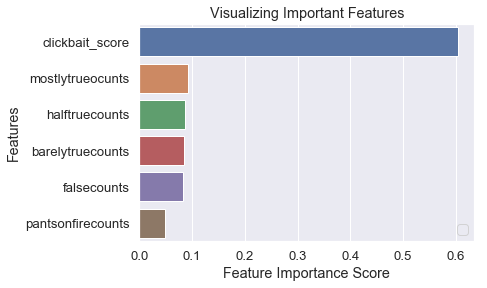


precision
0.339978190253
recall
0.338081273565
f1 score
0.338472682266


cross validation using 5:
[ 0.33333333  0.34547739  0.33249529  0.35135135  0.34005038]




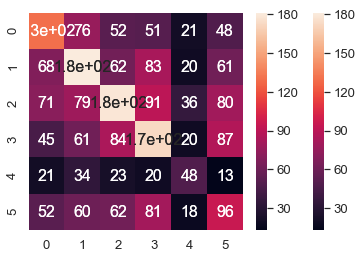

In [72]:
feat_importance()